# 0. Prerequisite

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.losses import MeanSquaredError, MeanAbsoluteError, CategoricalCrossentropy
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pandas as pd

class Benchmark:
    def __init__(self, name):
        self.name = name
        self.model = None
        self.scaler = dict()
        self.results = list()
        self.scaler_type = None

    def dataset(self, train_size=100):
        raise NotImplementedError

    def min_max_scaler(self, data, label='x'):
        from collections import defaultdict
        data_2d = np.reshape(data, (-1, 1)) if len(data.shape) ==1 else data
        print('data_2d: ', data_2d.shape)
        new_data = list()
        for i, d in enumerate(data_2d.T):
          scaler = MinMaxScaler()
          #d = scaler.fit_transform(np.reshape(d, (-1, 1)))
          new_data.append(scaler.fit_transform(np.reshape(d, (-1, 1))))
          key = '{:}{:}'.format(label, i)
          self.scaler[key] = scaler
        #print(self.scaler)
        print('new_data: ', np.squeeze(np.array(new_data), axis=2).T.shape)
        return np.squeeze(np.array(new_data), axis=2).T

    def standard_scaler(self, data, label='x'):
        from collections import defaultdict
        data_2d = np.reshape(data, (-1, 1)) if len(data.shape) ==1 else data
        print('data_2d: ', data_2d.shape)
        new_data = list()
        for i, d in enumerate(data_2d.T):
          scaler = StandardScaler()
          #d = scaler.fit_transform(np.reshape(d, (-1, 1)))
          new_data.append(scaler.fit_transform(np.reshape(d, (-1, 1))))
          key = '{:}{:}'.format(label, i)
          self.scaler[key] = scaler
        #print(self.scaler)
        print('new_data: ', np.squeeze(np.array(new_data), axis=2).T.shape)
        return np.squeeze(np.array(new_data), axis=2).T

    def inverse_transform(self, x, label='x'):
        print(len(self.scaler), self.scaler)
        x_2d = np.reshape(x, (-1, 1)) if len(x.shape) == 1 else x
        #print('inverse - x_2d: ', x_2d.shape)
        new_data = list()
        for i, d in enumerate(x_2d.T):
          key = '{:}{:}'.format(label, i)
          #print('inverse - d:', d.shape, 'key:', key)
          if key in self.scaler:
            #print('d.reshape:', np.reshape(d, (-1, 1)).shape)
            new_data.append(self.scaler[key].inverse_transform(np.reshape(d, (-1, 1))))
        #print('inverse - new_data: ', np.squeeze(np.array(new_data), axis=2).T.shape)
        return np.squeeze(np.array(new_data), axis=2).T

    def make_hyper_params(self):
        raise NotImplementedError

    def make_optimizer(self, name, lr):
        #print('make_optimizer', name)
        if name == 'Adam':
            return Adam(learning_rate=lr)
        elif name == 'RMSprop':
            return RMSprop(learning_rate=lr)
        elif name == 'SGD':
            return SGD(learning_rate=lr)
        else:
            raise ValueError('Unknown optimizer')

    def make_loss_func(self, name):
        if name == 'MAE':
            return MeanAbsoluteError()
        elif name == 'MSE':
            return MeanSquaredError()
        elif name == 'CCE':
            return CategoricalCrossentropy()         
        else:
            raise ValueError('Unknown loss function')

    def make_model(self, opt='Adam', lr='0.01', loss_fn='MSE', **kargs):
        raise NotImplementedError

    def train(self, X, y, epochs=50, batch=1, callbacks=None, **kargs):
        if self.model is not None:
          if 'scaler' in kargs.keys():
              self.scaler = dict()
              X_train_scaled = self.apply_scaler(X, 'x', scaler_type=kargs['scaler'])
              y_train_scaled = self.apply_scaler(y, 'y', scaler_type=kargs['scaler'])
          else:
              X_train_scaled = X
              y_train_scaled = y
          return self.model.fit(
              X_train_scaled, 
              y_train_scaled, 
              epochs=epochs,
              batch_size=batch, 
              callbacks=callbacks,
              verbose=kargs['verbose'],
              )

    def evaluate(self, X, y_true):
        if self.scaler_type is None:
          return self.model.evaluate(X_test, y_test)
        else:
          X_scaled = self.apply_scaler(X, 'x', self.scaler_type)
          y_true_scaled = self.apply_scaler(y_true, 'y', self.scaler_type)
          return self.model.evaluate(X_scaled, y_true_scaled)

    def predict(self, X):
        return self.model.predict(X)

    def get_result(self):
        return self.results[-1]

    def plot_result(self, ylabels=['loss'], xlabel='epochs'):
        parsed_results = self.get_result()
        #print('plot_result', parsed_results)
        n_plots = len(ylabels)
        fig, ax = plt.subplots(1, n_plots, figsize=(5*n_plots, 5))
        for i, ylabel in enumerate(ylabels):
          ax[i].plot(parsed_results[ylabel])
          ax[i].set_xlabel(xlabel)
          ax[i].set_ylabel(ylabel)
        plt.suptitle('The Best Performance Model for {}'.format(self.name))
        plt.show()

    def plot_predict_scaled(self, X, y_true):
        y_pred = self.predict(X)
        x_origin = self.inverse_transform(X, 'x')
        y_origin = self.inverse_transform(y_true, 'y')
        y_pred_origin = self.inverse_transform(y_pred, 'y')
        #plt.scatter(x_origin, y_origin)
        plt.plot(y_origin, label='True', color='blue')
        plt.plot(y_pred_origin, label='Predicted', color='red')
        plt.legend()
        plt.show()

    def plot_predict_unscaled(self, X, y_true):
        y_pred = self.predict(X)
        print('X: {}, y: {}, y_pred: {}'.format(X.shape, y_true.shape, y_pred.shape))
        #plt.scatter(X, y_true)
        plt.plot(y_true, label='True', color='blue')
        plt.plot(y_pred, label='Predicted', color='red')
        plt.legend()
        plt.show()

    def plot_predict(self, X, y_true, scaled=False):
        print('plot_predict', self.scaler_type)
        if self.scaler_type is None:
          self.plot_predict_unscaled(X, y_true)
        else:
          if not scaled:
            X_scaled = self.apply_scaler(X, 'x', self.scaler_type)
            y_true_scaled = self.apply_scaler(y_true, 'y', self.scaler_type)
          self.plot_predict_scaled(X_scaled, y_true_scaled)

    def summary(self):
        return self.model.summary()
    
    def apply_scaler(self, data, label='x', scaler_type='Standard'):
        print('apply_scaler: ', data.shape, label, scaler_type)
        self.scaler_type = scaler_type
        if self.scaler_type == 'Standard':
          return self.standard_scaler(data, label)
        elif self.scaler_type == 'MinMax':
          return self.min_max_scaler(data, label)

    def save_best_model(self):
        self.best_model = self.model
        self.best_scaler = self.scaler
        self.save_model()

    def save_model(self, model_path='./model'):
        self.model.save(model_path)

    def save_model_weights(self, checkpoint_path='./cp/cp-{epoch:04d}.ckpt'):
        return self.model.save_weights(checkpoint_path)

    def load_best_model(self):
        self.model = self.best_model
        self.scaler = self.best_scaler
        self.load_model()
        print(self.model.summary())
        print(self.best_param)
        print(self.best_scaler_type)
        print(self.scaler)

    def load_model(self, model_path='./model'):
        return load_model(model_path)

    def load_model_weights(self, checkpoint_path='./cp/cp-{epoch:04d}.ckpt'):
        return self.model.load_weights(checkpoint_path)

    def load_lastest_checkpoint(self, checkpoint_path='./cp'):
        latest = tf.keras.models.lastest_checkpoint(checkpoint_path)
        return self.model.load_weights(latest)

    def make_checkpoint_callback(self, save_best_only=True, period=5):
        filepath = "./cp/cp-{epoch:04d}.ckpt"
        checkpoint = ModelCheckpoint(
            filepath, 
            save_best_only=save_best_only,
            save_weights_only=False,
            monitor='val_loss',
            mode='min', 
            verbose=1, 
            save_freq='epoch', 
            period=period,
            )
        return checkpoint

    def make_tensorboard_callback(self, log_dir='./logs'):
        tensorboard = TensorBoard(log_dir=log_dir, histogram_freq=1, write_graph=True, write_images=True,
                                  update_freq='epoch', profile_batch=2, embeddings_freq=1)
        return tensorboard

    # TODO: how can we selelct the best model from the benchmark
    def benchmark(self, X, y, params=None):
        import sys
        X_train, X_test, y_train, y_test =\
         train_test_split(
             X, 
             y, 
             test_size=0.2, 
             random_state=42,
             )
        hyper_params = self.make_hyper_params() if params is None else params
        min_loss = sys.float_info.max
        for i, param in enumerate(hyper_params):
          print('*'*20)
          print('#{}, opt: {}, lr: {}, loss_fn: {}, batch: {}'\
                .format(i, param['opt'], param['lr'], param['loss_fn'], param['batch']))
          self.make_model(**param)
          record = self.train(X, y, **param)
          result = self.parse_result(record)
          print('loss', result['loss'])
          if result['loss'][-1] < min_loss:
            #print('loss: {:.2f}, weights: {}, bias: {}'\
            #      .format(result['loss'][-1], result['weights'], result['bias']))          
            score = self.evaluate(X_test, y_test)
            result['score'] = score
            self.results.append(result)
            self.best_param = param
            if 'scaler' in param.keys():
              self.best_scaler_type = param['scaler']
            self.save_best_model()
        self.load_best_model()
        return self.results


In [3]:
from tensorflow.keras.datasets import boston_housing

first = lambda x: x[0]
second = lambda x: x[1]

class MyBoustonHousingBenchmark(Benchmark):
    def __init__(self, name='BoustonHousing', train_size=100):
        super().__init__(name)
        #self.X, self.y = self.dataset(train_size)

    def dataset(self, shuffle=True, train_size=100):
          train, test = boston_housing.load_data()
          self.input_shape = first(train).shape[1]
          return train, test

    def make_hyper_params(self):
          self.params = {
              'opt': ['Adam', 'RMSprop', 'SGD'],
              'lr': [0.01, 0.001],
              'loss_fn': ['MSE'],
              'metrics': ['mae'],
              'batch': [16, 32, 64],
              # 'callbacks': [
              #   self.make_checkpoint_callback(save_best_only=False, period=5),
              # ],
              'validation_split': [0.2],
              'verbose': [0],
              'scaler': ['Standard'],
          }
          import itertools
          permutations_dicts = [dict(zip(self.params.keys(), v))  for v in itertools.product(*self.params.values())]
          print(permutations_dicts)
          return permutations_dicts

    def make_model(self, opt='Adam', lr='0.01', loss_fn='MSE', **kargs):
        self.model = Sequential()
        self.model.add(Input(shape=(self.input_shape,)))
        self.model.add(tf.keras.layers.Dense(units=10))
        self.model.add(tf.keras.layers.Dense(units=10))
        self.model.add(tf.keras.layers.Dense(units=1))
        #self.model.summary()
        #print(self.model.summary())
        optimizer = self.make_optimizer(opt, lr)
        loss_func = self.make_loss_func(loss_fn)
        self.model.compile(optimizer=optimizer, loss=loss_func, metrics=kargs['metrics'])
        #return self.model

    def parse_result(self, result):
        print('parse_result: ', result.history.keys())
        parsed_result = {
            'loss': result.history['loss'],
            'weights': self.model.layers[0].weights[:-1][0].numpy(),
            'bias': self.model.layers[0].weights[-1].numpy()
        }
        if 'metrics' in self.params:
          for m in self.params['metrics']:
            if m in result.history:
              parsed_result[m] = result.history[m]
        print('parsed_result: ', parsed_result.keys())
        return parsed_result

57026/57026 [==============================] - 0s 0us/step
X: (404, 13), y: (404,)
[{'opt': 'Adam', 'lr': 0.01, 'loss_fn': 'MSE', 'metrics': 'mae', 'batch': 16, 'validation_split': 0.2, 'verbose': 0, 'scaler': 'Standard'}, {'opt': 'Adam', 'lr': 0.01, 'loss_fn': 'MSE', 'metrics': 'mae', 'batch': 32, 'validation_split': 0.2, 'verbose': 0, 'scaler': 'Standard'}, {'opt': 'Adam', 'lr': 0.01, 'loss_fn': 'MSE', 'metrics': 'mae', 'batch': 64, 'validation_split': 0.2, 'verbose': 0, 'scaler': 'Standard'}, {'opt': 'Adam', 'lr': 0.001, 'loss_fn': 'MSE', 'metrics': 'mae', 'batch': 16, 'validation_split': 0.2, 'verbose': 0, 'scaler': 'Standard'}, {'opt': 'Adam', 'lr': 0.001, 'loss_fn': 'MSE', 'metrics': 'mae', 'batch': 32, 'validation_split': 0.2, 'verbose': 0, 'scaler': 'Standard'}, {'opt': 'Adam', 'lr': 0.001, 'loss_fn': 'MSE', 'metrics': 'mae', 'batch': 64, 'validation_split': 0.2, 'verbose': 0, 'scaler': 'Standard'}, {'opt': 'RMSprop', 'lr': 0.01, 'loss_fn': 'MSE', 'metrics': 'mae', 'batch': 16,

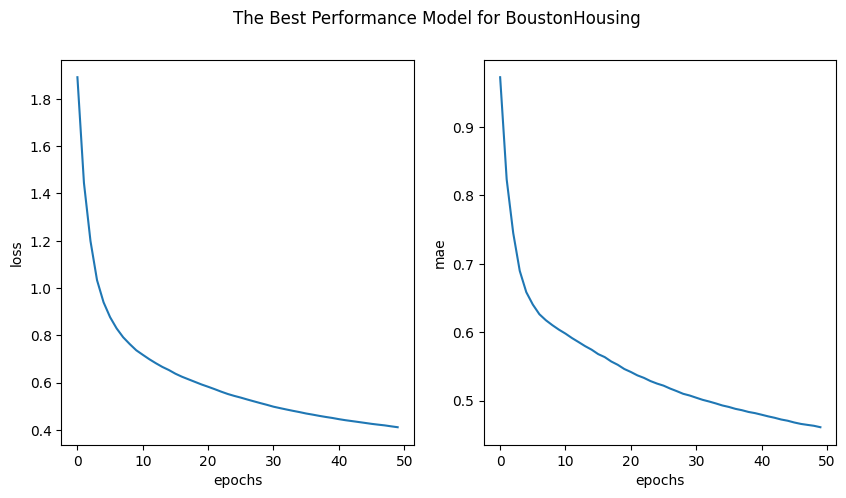

X: (102, 13), y: (102,)
plot_predict Standard
apply_scaler:  (102, 13) x Standard
data_2d:  (102, 13)
new_data:  (102, 13)
apply_scaler:  (102,) y Standard
data_2d:  (102, 1)
new_data:  (102, 1)
4/4 [==============================] - 0s 5ms/step
14 {'x0': StandardScaler(), 'x1': StandardScaler(), 'x2': StandardScaler(), 'x3': StandardScaler(), 'x4': StandardScaler(), 'x5': StandardScaler(), 'x6': StandardScaler(), 'x7': StandardScaler(), 'x8': StandardScaler(), 'x9': StandardScaler(), 'x10': StandardScaler(), 'x11': StandardScaler(), 'x12': StandardScaler(), 'y0': StandardScaler()}
14 {'x0': StandardScaler(), 'x1': StandardScaler(), 'x2': StandardScaler(), 'x3': StandardScaler(), 'x4': StandardScaler(), 'x5': StandardScaler(), 'x6': StandardScaler(), 'x7': StandardScaler(), 'x8': StandardScaler(), 'x9': StandardScaler(), 'x10': StandardScaler(), 'x11': StandardScaler(), 'x12': StandardScaler(), 'y0': StandardScaler()}
14 {'x0': StandardScaler(), 'x1': StandardScaler(), 'x2': StandardSc

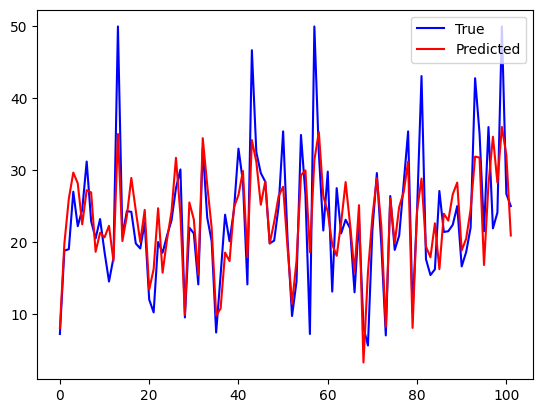

In [4]:
benchmark = MyBoustonHousingBenchmark()
train, test = benchmark.dataset()
X  = first(train)
y  = second(train)
print('X: {}, y: {}'.format(X.shape, y.shape))
result = benchmark.benchmark(X, y)
#print('score:', result[-1])
benchmark.plot_result(['loss', 'mae'])
X_test  = first(test)
y_test  = second(test)
print('X: {}, y: {}'.format(X_test.shape, y_test.shape))
benchmark.plot_predict(X_test, y_test)

In [ ]:
!ls ./model

ls: cannot access './model': No such file or directory


# ch6. datasets

## Step23 - Boston Housing Dataset

Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_61 (Dense)            (None, 10)                140       
                                                                 
 dense_62 (Dense)            (None, 10)                110       
                                                                 
 dense_63 (Dense)            (None, 1)                 11        
                                                                 
Total params: 261
Trainable params: 261
Non-trainable params: 0
_________________________________________________________________
13/13 - 0s - loss: 164.5265 - mae: 10.8755 - 31ms/epoch - 2ms/step
4/4 - 0s - loss: 175.3204 - mae: 11.4125 - 22ms/epoch - 5ms/step


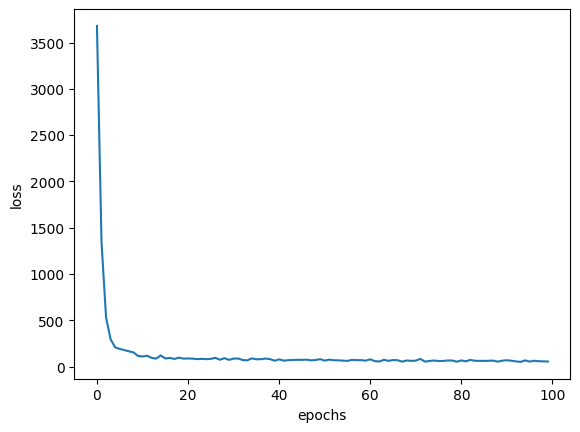

4/4 [==============================] - 0s 0s/step


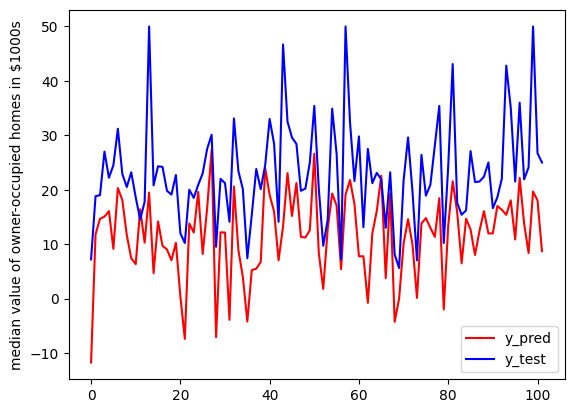

In [14]:
import tensorflow as tf
from tensorflow.keras.datasets import boston_housing
import numpy as np
import matplotlib.pyplot as plt

(x_train, y_train), (x_test, y_test) = boston_housing.load_data()
## print("x_train.shape=",x_train.shape) # (404, 13) # 13 개 특징 / 목표값 y_train, y_test 소유자의 거주 주택 중위 가격
##print("y_train.shape=",y_train.shape) # (404,)
##print("x_test.shape=", x_test.shape)  # (102, 13)
##print("y_test.shape=", y_test.shape)  # (102,)

model = tf.keras.Sequential()

#1: 1-layer
# model.add(tf.keras.layers.Dense(units=1, input_dim=x_train.shape[1]))# x_train.shape[1]=13

#2:  3-layer
model.add(tf.keras.layers.Dense(units=10, input_dim=x_train.shape[1]))
model.add(tf.keras.layers.Dense(units=10))
model.add(tf.keras.layers.Dense(units=1))
model.summary()

opt = tf.keras.optimizers.RMSprop(learning_rate=0.001)
model.compile(optimizer=opt, loss='mse', metrics=['mae']) #mean absolute error
ret = model.fit(x_train, y_train, epochs=100, validation_split=0.2, verbose=0)

train_loss = model.evaluate(x_train, y_train, verbose=2)
test_loss = model.evaluate(x_test, y_test, verbose=2)

loss = ret.history['loss']
plt.plot(loss)
plt.xlabel('epochs')
plt.ylabel('loss')
plt.show()

y_pred = model.predict(x_test)
#print("y_pred:", y_pred)

plt.ylabel("median value of owner-occupied homes in $1000s")
plt.plot(y_pred, "r-", label="y_pred")
plt.plot(y_test, "b-", label="y_test")
plt.legend(loc='best')
plt.show()


# Note - Text Preprocessing

* tokenize
* padding
* word embedding

In [1]:
import tensorflow as tf

# BTS 의 butter 가사

butter = """
Smooth like butter/
Like a criminal undercover/
Gon' pop like trouble/
Breakin' into your heart like that/
Cool shade stunner/
Yeah, I owe it all to my mother/
Hot like summer/
Yeah, I'm makin' you sweat like that/
Break it down/
"""
print(butter.split("/"))
butter = butter.split("/")
# butter = [line.strip() for line in butter]
butter = [line.split() for line in butter]

print(butter)
butter

['\nSmooth like butter', '\nLike a criminal undercover', "\nGon' pop like trouble", "\nBreakin' into your heart like that", '\nCool shade stunner', '\nYeah, I owe it all to my mother', '\nHot like summer', "\nYeah, I'm makin' you sweat like that", '\nBreak it down', '\n']
[['Smooth', 'like', 'butter'], ['Like', 'a', 'criminal', 'undercover'], ["Gon'", 'pop', 'like', 'trouble'], ["Breakin'", 'into', 'your', 'heart', 'like', 'that'], ['Cool', 'shade', 'stunner'], ['Yeah,', 'I', 'owe', 'it', 'all', 'to', 'my', 'mother'], ['Hot', 'like', 'summer'], ['Yeah,', "I'm", "makin'", 'you', 'sweat', 'like', 'that'], ['Break', 'it', 'down'], []]


[['Smooth', 'like', 'butter'],
 ['Like', 'a', 'criminal', 'undercover'],
 ["Gon'", 'pop', 'like', 'trouble'],
 ["Breakin'", 'into', 'your', 'heart', 'like', 'that'],
 ['Cool', 'shade', 'stunner'],
 ['Yeah,', 'I', 'owe', 'it', 'all', 'to', 'my', 'mother'],
 ['Hot', 'like', 'summer'],
 ['Yeah,', "I'm", "makin'", 'you', 'sweat', 'like', 'that'],
 ['Break', 'it', 'down'],
 []]

In [2]:
# 학습에 사용할 단어장을 만들어 보자!
tokenizer1 = tf.keras.preprocessing.text.Tokenizer()

# Updates internal vocabulary based on a list of sequences.
tokenizer1.fit_on_texts(butter)
# print('tokenizer1.word_index', tokenizer1.word_index)

print('tokenizer1.index_docs', tokenizer1.index_docs)
print('tokenizer1.index_word', tokenizer1.index_word) # 빈도수 순으로 순서 보장
# print('tokenizer1.word_index', tokenizer1.word_index) #
# print('tokenizer1.word_docs', tokenizer1.word_docs)
# print('tokenizer1.word_counts', tokenizer1.word_counts)
# print('tokenizer1.word_counts', sorted(tokenizer1.word_counts.items(), key=lambda x: x[1], reverse=True))


tokenizer1.index_docs defaultdict(<class 'int'>, {6: 1, 1: 6, 5: 1, 7: 1, 8: 1, 9: 1, 11: 1, 10: 1, 12: 1, 15: 1, 16: 1, 13: 1, 14: 1, 2: 2, 17: 1, 19: 1, 18: 1, 22: 1, 25: 1, 20: 1, 24: 1, 4: 2, 3: 2, 23: 1, 21: 1, 26: 1, 27: 1, 29: 1, 28: 1, 30: 1, 31: 1, 32: 1, 33: 1})
tokenizer1.index_word {1: 'like', 2: 'that', 3: 'yeah,', 4: 'it', 5: 'smooth', 6: 'butter', 7: 'a', 8: 'criminal', 9: 'undercover', 10: "gon'", 11: 'pop', 12: 'trouble', 13: "breakin'", 14: 'into', 15: 'your', 16: 'heart', 17: 'cool', 18: 'shade', 19: 'stunner', 20: 'i', 21: 'owe', 22: 'all', 23: 'to', 24: 'my', 25: 'mother', 26: 'hot', 27: 'summer', 28: "i'm", 29: "makin'", 30: 'you', 31: 'sweat', 32: 'break', 33: 'down'}


In [4]:
# 단어장을 이용해 butter 가사를 숫자로 변경해 보자!
encoded_butter=tokenizer1.texts_to_sequences(butter) # 텍스트를 숫자(인덱스) 로 변경해줌
encoded_butter
# tokenizer1.texts_to_sequences(butter)

[[5, 1, 6],
 [1, 7, 8, 9],
 [10, 11, 1, 12],
 [13, 14, 15, 16, 1, 2],
 [17, 18, 19],
 [3, 20, 21, 4, 22, 23, 24, 25],
 [26, 1, 27],
 [3, 28, 29, 30, 31, 1, 2],
 [32, 4, 33],
 []]

In [41]:
# OOV: Out-Of-Vocabulary
# 사전에서 빈도수 높은 단어 5개만 사용
# 사전에 없는 단어는? <OOV> 처리!
tokenizer1 = tf.keras.preprocessing.text.Tokenizer(num_words=5, oov_token='<OOV>')
tokenizer1.fit_on_texts(butter)
print('tokenizer1.index_docs', tokenizer1.index_docs)
print('tokenizer1.index_word', tokenizer1.index_word)
print('tokenizer1.word_index', tokenizer1.word_index)
encoded_butter = tokenizer1.texts_to_sequences(butter)
encoded_butter

tokenizer1.index_docs defaultdict(<class 'int'>, {6: 1, 7: 1, 2: 6, 9: 1, 8: 1, 10: 1, 13: 1, 11: 1, 12: 1, 14: 1, 17: 1, 3: 2, 16: 1, 15: 1, 18: 1, 20: 1, 19: 1, 21: 1, 23: 1, 5: 2, 25: 1, 24: 1, 4: 2, 22: 1, 26: 1, 27: 1, 28: 1, 31: 1, 30: 1, 32: 1, 29: 1, 33: 1, 34: 1})
tokenizer1.index_word {1: '<OOV>', 2: 'like', 3: 'that', 4: 'yeah', 5: 'it', 6: 'smooth', 7: 'butter', 8: 'a', 9: 'criminal', 10: 'undercover', 11: "gon'", 12: 'pop', 13: 'trouble', 14: "breakin'", 15: 'into', 16: 'your', 17: 'heart', 18: 'cool', 19: 'shade', 20: 'stunner', 21: 'i', 22: 'owe', 23: 'all', 24: 'to', 25: 'my', 26: 'mother', 27: 'hot', 28: 'summer', 29: "i'm", 30: "makin'", 31: 'you', 32: 'sweat', 33: 'break', 34: 'down'}
tokenizer1.word_index {'<OOV>': 1, 'like': 2, 'that': 3, 'yeah': 4, 'it': 5, 'smooth': 6, 'butter': 7, 'a': 8, 'criminal': 9, 'undercover': 10, "gon'": 11, 'pop': 12, 'trouble': 13, "breakin'": 14, 'into': 15, 'your': 16, 'heart': 17, 'cool': 18, 'shade': 19, 'stunner': 20, 'i': 21, 'ow

[[1, 2, 1],
 [2, 1, 1, 1],
 [1, 1, 2, 1],
 [1, 1, 1, 1, 2, 3],
 [1, 1, 1],
 [4, 1, 1, 1, 1, 1, 1, 1],
 [1, 2, 1],
 [4, 1, 1, 1, 1, 2, 3],
 [1, 1, 1],
 []]

In [55]:
# 문장의 길이가 다르므로 일치시켜 보자! 
# (MNIST 이미지 데이터의 모양은 모두 28 x 28)
from tensorflow.keras.preprocessing.sequence import pad_sequences
encoded_butter=pad_sequences(encoded_butter)
pad_sequences(encoded_butter)
#pad_sequences(encoded_butter, padding='post')

array([[ 0,  0,  0,  0,  0,  5,  1,  6],
       [ 0,  0,  0,  0,  1,  7,  8,  9],
       [ 0,  0,  0,  0, 10, 11,  1, 12],
       [ 0,  0, 13, 14, 15, 16,  1,  2],
       [ 0,  0,  0,  0,  0, 17, 18, 19],
       [ 3, 20, 21,  4, 22, 23, 24, 25],
       [ 0,  0,  0,  0,  0, 26,  1, 27],
       [ 0,  3, 28, 29, 30, 31,  1,  2],
       [ 0,  0,  0,  0,  0, 32,  4, 33],
       [ 0,  0,  0,  0,  0,  0,  0,  0]])

In [56]:
pad_sequences(encoded_butter, maxlen=6)

array([[ 0,  0,  0,  5,  1,  6],
       [ 0,  0,  1,  7,  8,  9],
       [ 0,  0, 10, 11,  1, 12],
       [13, 14, 15, 16,  1,  2],
       [ 0,  0,  0, 17, 18, 19],
       [21,  4, 22, 23, 24, 25],
       [ 0,  0,  0, 26,  1, 27],
       [28, 29, 30, 31,  1,  2],
       [ 0,  0,  0, 32,  4, 33],
       [ 0,  0,  0,  0,  0,  0]])

In [57]:
# Dense Layer 에 입력으로 사용해 보자!
# one-hot encoding
# Converts a class vector (integers) to binary class matrix.
# tf.keras.utils.to_categorical([0, 1, 2, 3], num_classes=4)
from tensorflow.keras.utils import to_categorical
to_categorical(encoded_butter[0])

array([[1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0.],
       [0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1.]], dtype=float32)

## Step24 - IMDB Dataset

* 영화 리뷰 데이터
* 훈련 데이터 2.5만개, 테스트 데이터 2.5만개
* 긍정/부정

In [77]:
from tensorflow.keras.datasets import imdb 
import numpy as np

#1
(x_train, y_train), (x_test, y_test) = imdb.load_data() # index_from=3

# y_train[1]
print(len(x_train[1]))
print(list(x_train[1]))
#2
#(x_train, y_train), (x_test, y_test) = imdb.load_data(skip_top=15, num_words=101)

189
[1, 194, 1153, 194, 8255, 78, 228, 5, 6, 1463, 4369, 5012, 134, 26, 4, 715, 8, 118, 1634, 14, 394, 20, 13, 119, 954, 189, 102, 5, 207, 110, 3103, 21, 14, 69, 188, 8, 30, 23, 7, 4, 249, 126, 93, 4, 114, 9, 2300, 1523, 5, 647, 4, 116, 9, 35, 8163, 4, 229, 9, 340, 1322, 4, 118, 9, 4, 130, 4901, 19, 4, 1002, 5, 89, 29, 952, 46, 37, 4, 455, 9, 45, 43, 38, 1543, 1905, 398, 4, 1649, 26, 6853, 5, 163, 11, 3215, 10156, 4, 1153, 9, 194, 775, 7, 8255, 11596, 349, 2637, 148, 605, 15358, 8003, 15, 123, 125, 68, 23141, 6853, 15, 349, 165, 4362, 98, 5, 4, 228, 9, 43, 36893, 1157, 15, 299, 120, 5, 120, 174, 11, 220, 175, 136, 50, 9, 4373, 228, 8255, 5, 25249, 656, 245, 2350, 5, 4, 9837, 131, 152, 491, 18, 46151, 32, 7464, 1212, 14, 9, 6, 371, 78, 22, 625, 64, 1382, 9, 8, 168, 145, 23, 4, 1690, 15, 16, 4, 1355, 5, 28, 6, 52, 154, 462, 33, 89, 78, 285, 16, 145, 95]


In [79]:
index = imdb.get_word_index()
reverse_index  = dict([(value, key) for (key, value) in index.items()]) 
# review = " ".join( [reverse_index.get(i-3, "?") for i in x_train[n]] )
# print("review of x_train[{}]:\n{}".format(n, review))
for i in x_train[1]:
    print(reverse_index[i], end=" ")
# reverse_index

the thought solid thought senator do making to is spot nomination assumed while he of jack in where picked as getting on was did hands fact characters to always life thrillers not as me can't in at are br of sure your way of little it strongly random to view of love it so principles of guy it used producer of where it of here icon film of outside to don't all unique some like of direction it if out her imagination below keep of queen he diverse to makes this stretch stefan of solid it thought begins br senator machinations budget worthwhile though ok brokedown awaiting for ever better were lugia diverse for budget look kicked any to of making it out bosworth's follows for effects show to show cast this family us scenes more it severe making senator to levant's finds tv tend to of emerged these thing wants but fuher an beckinsale cult as it is video do you david see scenery it in few those are of ship for with of wild to one is very work dark they don't do dvd with those them 

In [80]:
from tensorflow.keras.datasets import imdb 
import numpy as np

#1
(x_train, y_train), (x_test, y_test) = imdb.load_data() # index_from=3

#2
#(x_train, y_train), (x_test, y_test) = imdb.load_data(skip_top=15, num_words=101)

##print("x_train.shape=",x_train.shape) # (25000,)
##print("y_train.shape=",y_train.shape) # (25000,)
##print("x_test.shape=", x_test.shape)  # (25000,)
##print("y_test.shape=", y_test.shape)  # (25000,)

#3
##nlabel, count = np.unique(y_train, return_counts=True)
##print("nlabel:", nlabel)
##print("count:",  count)
##print("# of Class:",  len(nlabel) ) # 2

print("max(x_train words):", max(len(x) for x in x_train)) # 2494
print("max(x_test words):",  max(len(x) for x in x_test)) # 2315
print("x_train[0]:", x_train[0])
print("y_train[0]:", y_train[0])

#4: decoding x_train[n], reverse from integers to words
# ref: https://builtin.com/data-science/how-build-neural-network-keras
n = 0
index = imdb.get_word_index()
reverse_index  = dict([(value, key) for (key, value) in index.items()]) 
review = " ".join( [reverse_index.get(i-3, "?") for i in x_train[n]] )
print("review of x_train[{}]:\n{}".format(n, review))

max(x_train words): 2494
max(x_test words): 2315
x_train[0]: [1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 22665, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 21631, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 19193, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 10311, 8, 4, 107, 117, 5952, 15, 256, 4, 31050, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 12118, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15

In [88]:
import tensorflow as tf
import numpy as np
#1
texts = ['This is a film','This is not a film']
top_words= 10 # maximum integer index + 1

#2
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=top_words)
tokenizer.fit_on_texts(texts)
print("tokenizer.word_index:",tokenizer.word_index)

#3
sequences = tokenizer.texts_to_sequences(texts)
print("sequences:",sequences)

#4: each vector length: top_words = 10
output_vector = tokenizer.sequences_to_matrix(sequences) # mode='binary' # 숫자를 메트릭스로 (임베딩)
print("output_vector.shape=", output_vector.shape) # (2, 10)
print(output_vector)

tokenizer.word_index: {'this': 1, 'is': 2, 'a': 3, 'film': 4, 'not': 5}
sequences: [[1, 2, 3, 4], [1, 2, 5, 3, 4]]
output_vector.shape= (2, 10)
[[0. 1. 1. 1. 1. 0. 0. 0. 0. 0.]
 [0. 1. 1. 1. 1. 1. 0. 0. 0. 0.]]


In [91]:
import tensorflow as tf
import numpy as np
#1
texts = ['This is a film','This is not a film']
top_words    = 10  # maximum integer index + 1
max_words    = 6  # sequences.shape[1]
vecor_length = 3  # dimension of the dense embedding

#2
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=top_words)
tokenizer.fit_on_texts(texts)
print("tokenizer.word_index:",tokenizer.word_index)

#3
sequences = tokenizer.texts_to_sequences(texts)
print("sequences:",sequences)

#4
sequences = tf.keras.preprocessing.sequence.pad_sequences(sequences, max_words)
print('sequences.shape=', sequences.shape)
print("sequences:", sequences)

#5
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(input_dim =top_words, output_dim=vecor_length))
##model.add(tf.keras.layers.Flatten()) # output_vector.shape = (2, 18)
model.summary()

#6
output_vector = model.predict(sequences)
print("output_vector.shape:", output_vector.shape )
print("output_vector:", output_vector )

tokenizer.word_index: {'this': 1, 'is': 2, 'a': 3, 'film': 4, 'not': 5}
sequences: [[1, 2, 3, 4], [1, 2, 5, 3, 4]]
sequences.shape= (2, 6)
sequences: [[0 0 1 2 3 4]
 [0 1 2 5 3 4]]
Model: "sequential_30"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, None, 3)           30        
                                                                 
Total params: 30
Trainable params: 30
Non-trainable params: 0
_________________________________________________________________
1/1 [==============================] - 0s 23ms/step
output_vector.shape: (2, 6, 3)
output_vector: [[[-0.0089 -0.0239 -0.0386]
  [-0.0089 -0.0239 -0.0386]
  [ 0.0499 -0.0458  0.0169]
  [-0.0006  0.0252 -0.0381]
  [-0.0059  0.0022  0.0089]
  [ 0.0388  0.0328 -0.0343]]

 [[-0.0089 -0.0239 -0.0386]
  [ 0.0499 -0.0458  0.0169]
  [-0.0006  0.0252 -0.0381]
  [ 0.0391 -0.0009 -0.0152]
  [-0.0059  0.0022  0.00

In [92]:
import tensorflow as tf
from tensorflow.keras.datasets import imdb
import numpy as np
import matplotlib.pyplot as plt
#1
top_words    = 1000
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=top_words)
##print("x_train.shape=",x_train.shape) # (25000,)
##print("x_test.shape=", x_test.shape)  # (25000,)

#2: binary encoding
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=top_words)
x_train = tokenizer.sequences_to_matrix(x_train) # mode='binary'
x_test = tokenizer.sequences_to_matrix(x_test)
##print("x_train.shape=",x_train.shape) # (25000, 1000)
##print("x_test.shape=", x_test.shape)  # (25000, 1000)

# one-hot encoding: 'mse', 'categorical_crossentropy'  
y_train = tf.keras.utils.to_categorical(y_train)
y_test = tf.keras.utils.to_categorical(y_test)
##print("y_train=", y_train)
##print("y_test=", y_test)

#3
model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(units=10, input_dim = top_words, activation='sigmoid'))
model.add(tf.keras.layers.Dense(units=2, activation='softmax'))
model.summary()

opt = tf.keras.optimizers.RMSprop(learning_rate=0.01)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
ret = model.fit(x_train, y_train, epochs=100, batch_size=1280, verbose=0)

#4
train_loss, train_acc = model.evaluate(x_train, y_train, verbose=2) # 학습 결과는 좋으나
test_loss, test_acc = model.evaluate(x_test,  y_test, verbose=2) # 예측 결과가 별로임

Model: "sequential_31"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_78 (Dense)            (None, 10)                10010     
                                                                 
 dense_79 (Dense)            (None, 2)                 22        
                                                                 
Total params: 10,032
Trainable params: 10,032
Non-trainable params: 0
_________________________________________________________________
782/782 - 1s - loss: 0.0468 - accuracy: 0.9905 - 1s/epoch - 1ms/step
782/782 - 1s - loss: 0.7175 - accuracy: 0.8298 - 1s/epoch - 2ms/step


Model: "sequential_32"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, 100, 10)           10000     
                                                                 
 flatten_5 (Flatten)         (None, 1000)              0         
                                                                 
 dense_80 (Dense)            (None, 10)                10010     
                                                                 
 dense_81 (Dense)            (None, 2)                 22        
                                                                 
Total params: 20,032
Trainable params: 20,032
Non-trainable params: 0
_________________________________________________________________


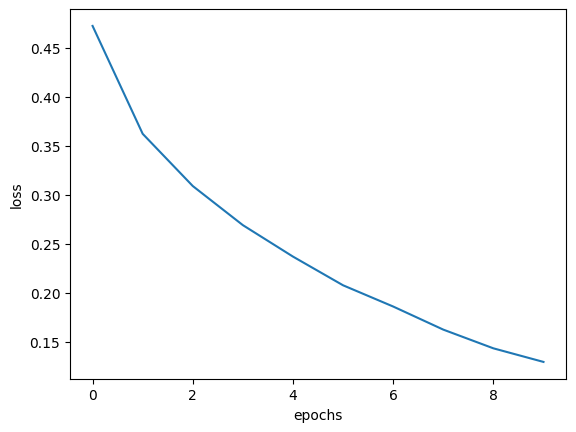

782/782 - 1s - loss: 0.0881 - accuracy: 0.9771 - 1s/epoch - 1ms/step
782/782 - 1s - loss: 0.7291 - accuracy: 0.7814 - 1s/epoch - 1ms/step


In [93]:
import tensorflow as tf
from tensorflow.keras.datasets import imdb
import numpy as np
import matplotlib.pyplot as plt
#1
top_words    = 1000
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=top_words)
##print("x_train.shape=",x_train.shape) # (25000,)
##print("x_test.shape=", x_test.shape)  # (25000,)

#2
max_words = 100
x_train= tf.keras.preprocessing.sequence.pad_sequences(x_train, maxlen=max_words)
x_test = tf.keras.preprocessing.sequence.pad_sequences(x_test,  maxlen=max_words)
####print("x_train.shape=",x_train.shape) # (25000, 100)
####print("x_test.shape=", x_test.shape)  # (25000, 100)

# one-hot encoding: 'mse', 'categorical_crossentropy'  
y_train = tf.keras.utils.to_categorical(y_train)
y_test = tf.keras.utils.to_categorical(y_test)
##print("y_train=", y_train)
##print("y_test=", y_test)

#3
vecor_length = 10   # dimension of the dense embedding
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(input_dim =top_words,
                                    output_dim=vecor_length,
                                    input_length=max_words))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(units=10, activation='sigmoid'))
model.add(tf.keras.layers.Dense(units=2, activation='softmax'))
model.summary()

opt = tf.keras.optimizers.RMSprop(learning_rate=0.01)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
ret = model.fit(x_train, y_train, epochs=10, batch_size=128, verbose=0)
loss = ret.history['loss']
plt.plot(loss)
plt.xlabel('epochs')
plt.ylabel('loss')
plt.show()

#4
train_loss, train_acc = model.evaluate(x_train, y_train, verbose=2)
test_loss, test_acc = model.evaluate(x_test,  y_test, verbose=2)

TypeError: 'tuple' object is not callable

## Step25 - Reuters Dataset

* 로이터 뉴스 기사
* 훈련 데이터 약 9천개, 테스트 데이터 약 2천개
* 46 종류의 카테고리

In [101]:
import tensorflow as tf
from tensorflow.keras.datasets import reuters
import numpy as np
import matplotlib.pyplot as plt
#1
(x_train, y_train), (x_test, y_test) = reuters.load_data()
# x_train[1]

In [103]:
np.unique(y_train)
label = ('cocoa','grain','veg-oil','earn','acq','wheat','copper','housing',
              'money-supply','coffee','sugar','trade','reserves','ship','cotton',
              'carcass','crude','nat-gas','cpi','money-fx','interest','gnp',
              'meal-feed','alum','oilseed','gold','tin','strategic-metal',
              'livestock','retail','ipi','iron-steel','rubber','heat','jobs',
              'lei','bop','zinc','orange','pet-chem','dlr','gas','silver','wpi','hog','lead')
label(y_train[1])

TypeError: 'tuple' object is not callable

In [104]:
import tensorflow as tf
from tensorflow.keras.datasets import reuters
import numpy as np
import matplotlib.pyplot as plt
#1
(x_train, y_train), (x_test, y_test) = reuters.load_data()

#2
##(x_train, y_train), (x_test, y_test) = reuters.load_data(skip_top=15, num_words=101)
##print("x_train.shape=",x_train.shape) # (8982,)
##print("y_train.shape=",y_train.shape) # (8982,)
##print("x_test.shape=", x_test.shape)  # (2246,)
##print("y_test.shape=", y_test.shape)  # (2246,)

#3
##nlabel, count = np.unique(y_train, return_counts=True)
##print("nlabel:", nlabel)
##print("count:",  count)
##print("# of Class:",  len(nlabel) ) # 46 

##print("max(x_train words):", max(len(x) for x in x_train))# 2376
##print("max(x_test words):",  max(len(x) for x in x_test)) # 1032

#https://github.com/SteffenBauer/KerasTools/blob/master/KerasTools/datasets/decode.py
label = ('cocoa','grain','veg-oil','earn','acq','wheat','copper','housing',
              'money-supply','coffee','sugar','trade','reserves','ship','cotton',
              'carcass','crude','nat-gas','cpi','money-fx','interest','gnp',
              'meal-feed','alum','oilseed','gold','tin','strategic-metal',
              'livestock','retail','ipi','iron-steel','rubber','heat','jobs',
              'lei','bop','zinc','orange','pet-chem','dlr','gas','silver','wpi','hog','lead')
##print("x_train[0]:", x_train[0])

#4: decoding x_train[n], reverse from integers to words
# 0, 1, 2: 'padding', 'start of sequence', and 'unknown word'
n = 0 # n = 584, it's cocoa news
print("y_train[{}]={}".format(n, y_train[n]))
print("News label: {}".format(label[y_train[n]]))

index = reuters.get_word_index()
reverse_index  = dict([(value, key) for (key, value) in index.items()]) 
review = " ".join( [reverse_index.get(i-3, "?") for i in x_train[n]] )
print("review of x_train[{}]:\n{}".format(n, review))

y_train[0]=3
News label: earn
550378/550378 [==============================] - 1s 1us/step
review of x_train[0]:
? mcgrath rentcorp said as a result of its december acquisition of space co it expects earnings per share in 1987 of 1 15 to 1 30 dlrs per share up from 70 cts in 1986 the company said pretax net should rise to nine to 10 mln dlrs from six mln dlrs in 1986 and rental operation revenues to 19 to 22 mln dlrs from 12 5 mln dlrs it said cash flow per share this year should be 2 50 to three dlrs reuter 3


In [105]:
import tensorflow as tf
from tensorflow.keras.datasets import reuters
import numpy as np
import matplotlib.pyplot as plt
#1
top_words    = 1000
(x_train, y_train), (x_test, y_test) = reuters.load_data(num_words=top_words)
##print("x_train.shape=",x_train.shape) # (8982,)
##print("x_test.shape=", x_test.shape)  # (2246,)

#2: binary encoding
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=top_words)
x_train = tokenizer.sequences_to_matrix(x_train) # mode='binary'
x_test = tokenizer.sequences_to_matrix(x_test)
##print("x_train.shape=",x_train.shape) # (8982, 1000)
##print("x_test.shape=", x_test.shape)  # (2246, 1000)

# one-hot encoding: 'mse', 'categorical_crossentropy'  
y_train = tf.keras.utils.to_categorical(y_train)
y_test = tf.keras.utils.to_categorical(y_test)
##print("y_train=", y_train)
##print("y_test=", y_test)

#3
model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(units=10, input_dim = top_words, activation='sigmoid'))
model.add(tf.keras.layers.Dense(units=46, activation='softmax'))
model.summary()

opt = tf.keras.optimizers.RMSprop(learning_rate=0.01)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
ret = model.fit(x_train, y_train, epochs=100, batch_size=128, verbose=2)
##loss = ret.history['loss']
##plt.plot(loss)
##plt.xlabel('epochs')
##plt.ylabel('loss')
##plt.show()

#4
train_loss, train_acc = model.evaluate(x_train, y_train, verbose=2)
test_loss, test_acc = model.evaluate(x_test,  y_test, verbose=2)

Model: "sequential_33"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_82 (Dense)            (None, 10)                10010     
                                                                 
 dense_83 (Dense)            (None, 46)                506       
                                                                 
Total params: 10,516
Trainable params: 10,516
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
71/71 - 1s - loss: 1.9678 - accuracy: 0.5183 - 664ms/epoch - 9ms/step
Epoch 2/100
71/71 - 0s - loss: 1.2705 - accuracy: 0.6860 - 179ms/epoch - 3ms/step
Epoch 3/100
71/71 - 0s - loss: 1.0410 - accuracy: 0.7640 - 146ms/epoch - 2ms/step
Epoch 4/100
71/71 - 0s - loss: 0.9028 - accuracy: 0.7923 - 155ms/epoch - 2ms/step
Epoch 5/100
71/71 - 0s - loss: 0.8054 - accuracy: 0.8102 - 163ms/epoch - 2ms/step
Epoch 6/100
71/71 - 0s - loss: 0.73

In [106]:
import tensorflow as tf
from tensorflow.keras.datasets import reuters
import numpy as np
import matplotlib.pyplot as plt

#1
top_words    = 1000
(x_train, y_train), (x_test, y_test) = reuters.load_data(num_words=top_words)
##print("x_train.shape=",x_train.shape) # (8982,)
##print("x_test.shape=", x_test.shape)  # (2246,)
 
#2
max_words = 100
x_train= tf.keras.preprocessing.sequence.pad_sequences(x_train, maxlen=max_words)
x_test = tf.keras.preprocessing.sequence.pad_sequences(x_test,  maxlen=max_words)
####print("x_train.shape=",x_train.shape) # (8982, 100)
####print("x_test.shape=", x_test.shape)  # (2246, 100)

# one-hot encoding: 'mse', 'categorical_crossentropy'  
y_train = tf.keras.utils.to_categorical(y_train)
y_test = tf.keras.utils.to_categorical(y_test)
##print("y_train=", y_train)
##print("y_test=", y_test)

#3
vecor_length = 10    # dimension of the dense embedding
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(input_dim =top_words,
                                    output_dim=vecor_length,
                                    input_length=max_words))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(units=10, activation='sigmoid'))
model.add(tf.keras.layers.Dense(units=46, activation='softmax'))
model.summary()

opt = tf.keras.optimizers.RMSprop(learning_rate=0.01)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
ret = model.fit(x_train, y_train, epochs=100, batch_size=128, verbose=0)
##loss = ret.history['loss']
##plt.plot(loss)
##plt.xlabel('epochs')
##plt.ylabel('loss')
##plt.show()

#4
train_loss, train_acc = model.evaluate(x_train, y_train, verbose=2)
test_loss, test_acc = model.evaluate(x_test,  y_test, verbose=2)

Model: "sequential_34"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_8 (Embedding)     (None, 100, 10)           10000     
                                                                 
 flatten_6 (Flatten)         (None, 1000)              0         
                                                                 
 dense_84 (Dense)            (None, 10)                10010     
                                                                 
 dense_85 (Dense)            (None, 46)                506       
                                                                 
Total params: 20,516
Trainable params: 20,516
Non-trainable params: 0
_________________________________________________________________
281/281 - 0s - loss: 0.2021 - accuracy: 0.9472 - 490ms/epoch - 2ms/step
71/71 - 0s - loss: 4.0075 - accuracy: 0.6175 - 117ms/epoch - 2ms/step


## Step26 - MNIST Dataset

* 0~9까지의 숫자를 손으로 쓴 글자 이미지
* 훈련 데이터 6만개, 테스트 데이터 1만개
* 28 x 28, 1 채널 (784)

x_train.shape= (60000, 28, 28)
y_train.shape= (60000,)
x_test.shape= (10000, 28, 28)
y_test.shape= (10000,)
nlabel: [0 1 2 3 4 5 6 7 8 9]
count: [5923 6742 5958 6131 5842 5421 5918 6265 5851 5949]
# of Class: 10
y_train[:8]= [5 0 4 1 9 2 1 3]


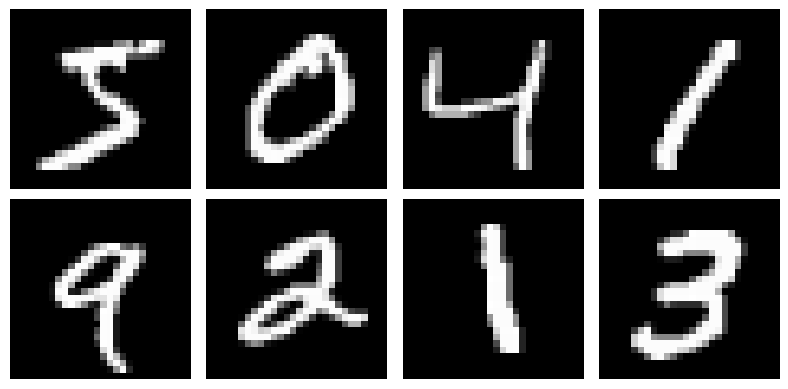

In [108]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
#1
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
print("x_train.shape=", x_train.shape) # (60000, 28, 28)
print("y_train.shape=", y_train.shape) # (60000,)
print("x_test.shape=",  x_test.shape)  # (10000, 28, 28)
print("y_test.shape=",  y_test.shape)  # (10000,)

#2
nlabel, count = np.unique(y_train, return_counts=True)
print("nlabel:", nlabel)
print("count:",  count)
print("# of Class:",  len(nlabel) )

#3: display images
print("y_train[:8]=",y_train[:8])
fig = plt.figure(figsize=(8, 4))
for i in range(8):
    plt.subplot(2, 4, i + 1)  
    plt.imshow(x_train[i], cmap='gray')
    plt.axis("off")
fig.tight_layout()
plt.show()

In [120]:
y_train[:, :30]

array([[0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.]], dtype=float32)

Model: "sequential_35"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_7 (Flatten)         (None, 784)               0         
                                                                 
 dense_86 (Dense)            (None, 20)                15700     
                                                                 
 dense_87 (Dense)            (None, 10)                210       
                                                                 
Total params: 15,910
Trainable params: 15,910
Non-trainable params: 0
_________________________________________________________________
1875/1875 [==============================] - 2s 859us/step
confusion_matrix(C): tf.Tensor(
[[5878    0   13    2    2    6    8    1   12    1]
 [   0 6707   11    5    2    1    2    1   11    2]
 [   7   13 5858   19    5    7    5   11   29    4]
 [   2   16   51 5971    4   26    0    7   38   16]
 [   3    

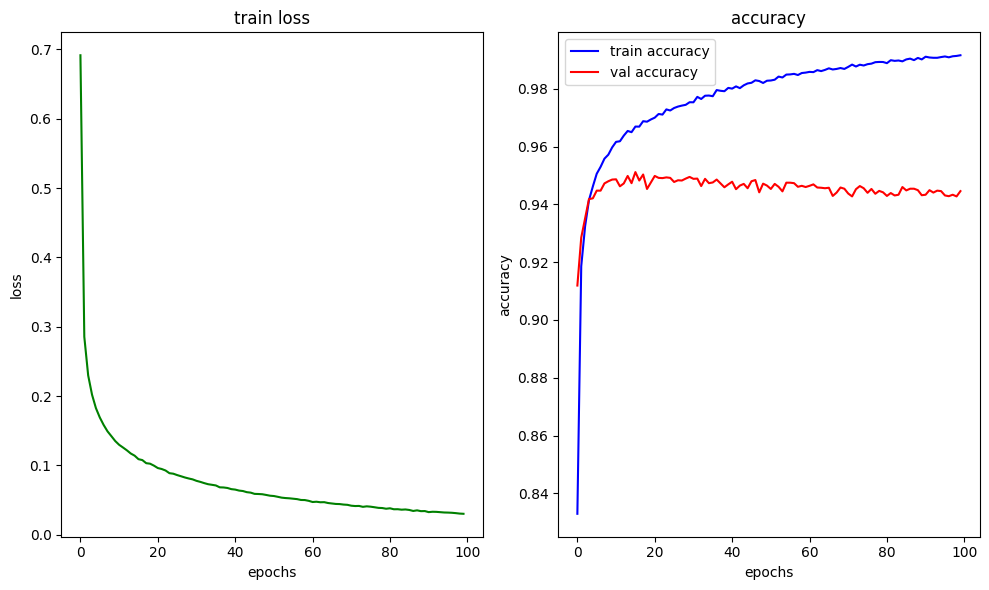

In [109]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
#1
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
##print("x_train.shape=", x_train.shape) # (60000, 28, 28)
##print("y_train.shape=", y_train.shape) # (60000,)
##print("x_test.shape=",  x_test.shape)  # (10000, 28, 28)
##print("y_test.shape=",  y_test.shape)  # (10000,)

#2:normalize images
x_train = x_train.astype('float32')
x_test  = x_test.astype('float32')
x_train /= 255.0 # [0.0, 1.0]
x_test  /= 255.0

#3: one-hot encoding
y_train = tf.keras.utils.to_categorical(y_train) # (60000, 10)
y_test = tf.keras.utils.to_categorical(y_test)   # (10000, 10)

#4: x_train.shape = (60000, 28, 28)
model = tf.keras.Sequential()
model.add(tf.keras.layers.Flatten(input_shape=(28, 28)))
model.add(tf.keras.layers.Dense(units=20, activation='sigmoid'))
model.add(tf.keras.layers.Dense(units=10, activation='softmax'))
model.summary()

##model = tf.keras.Sequential()
##model.add(tf.keras.layers.Input(shape = (28,28)))
##model.add(tf.keras.layers.Flatten())
##model.add(tf.keras.layers.Dense(units=20))
##model.add(tf.keras.layers.Activation('sigmoid'))
##model.add(tf.keras.layers.Dense(units=10))
##model.add(tf.keras.layers.Activation('softmax'))
##model.summary()

opt = tf.keras.optimizers.RMSprop(learning_rate=0.01)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
ret = model.fit(x_train, y_train, epochs=100, batch_size=400,
                validation_split=0.2, verbose=0)

#5
y_pred = model.predict(x_train)
y_label = np.argmax(y_pred, axis = 1)
C = tf.math.confusion_matrix(np.argmax(y_train, axis = 1), y_label)
print("confusion_matrix(C):", C)

train_loss, train_acc = model.evaluate(x_train, y_train, verbose=2)
test_loss, test_acc = model.evaluate(x_test,  y_test, verbose=2)

#6
fig, ax = plt.subplots(1, 2, figsize=(10, 6))
ax[0].plot(ret.history['loss'],  "g-")
ax[0].set_title("train loss")
ax[0].set_xlabel('epochs')
ax[0].set_ylabel('loss')

ax[1].plot(ret.history['accuracy'],     "b-", label="train accuracy")
ax[1].plot(ret.history['val_accuracy'], "r-", label="val accuracy")
ax[1].set_title("accuracy")
ax[1].set_xlabel('epochs')
ax[1].set_ylabel('accuracy')
plt.legend(loc="best")
fig.tight_layout()
plt.show()

## Step27 - Fashion_MNIST Dataset

* 10 종류의 패션 아이템(신발, 티셔츠 등) 의 이미지
* 훈련 데이터 6만개, 테스트 데이터 1만개
* 28 x 28, 1 채널

4422102/4422102 [==============================] - 0s 0us/step
x_train.shape= (60000, 28, 28)
y_train.shape= (60000,)
x_test.shape= (10000, 28, 28)
y_test.shape= (10000,)
nlabel: [0 1 2 3 4 5 6 7 8 9]
count: [6000 6000 6000 6000 6000 6000 6000 6000 6000 6000]
# of Class: 10
y_train[:8]= [9 0 0 3 0 2 7 2]


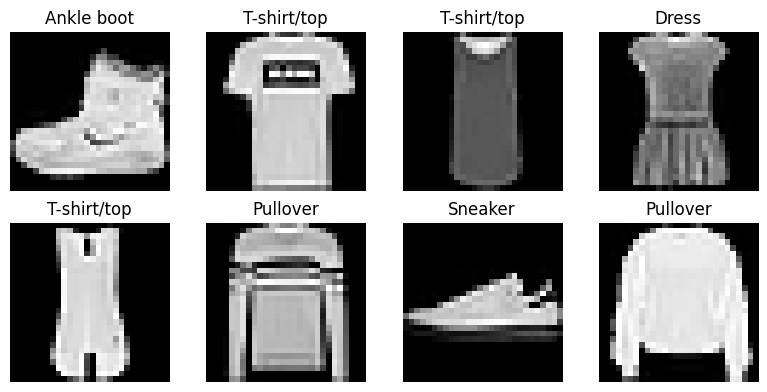

In [ ]:
import tensorflow as tf
from tensorflow.keras.datasets import fashion_mnist
import numpy as np
import matplotlib.pyplot as plt

#1
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
print("x_train.shape=", x_train.shape) # (60000, 28, 28)
print("y_train.shape=", y_train.shape) # (60000,)
print("x_test.shape=",  x_test.shape)  # (10000, 28, 28)
print("y_test.shape=",  y_test.shape)  # (10000,)

#2
nlabel, count = np.unique(y_train, return_counts=True)
print("nlabel:", nlabel)
print("count:",  count)
print("# of Class:",  len(nlabel) ) # 10

#3: display images
label = ('T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
          'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot')

print("y_train[:8]=", y_train[:8])
fig = plt.figure(figsize=(8, 4))
for i in range(8):
    plt.subplot(2, 4, i + 1, )  
    plt.imshow(x_train[i], cmap='gray')
    plt.gca().set_title(label[y_train[i]])
    plt.axis("off")
fig.tight_layout()
plt.show()

Model: "sequential_36"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_8 (Flatten)         (None, 784)               0         
                                                                 
 dense_88 (Dense)            (None, 20)                15700     
                                                                 
 dense_89 (Dense)            (None, 10)                210       
                                                                 
Total params: 15,910
Trainable params: 15,910
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
120/120 - 1s - loss: 0.8602 - accuracy: 0.7190 - val_loss: 0.5391 - val_accuracy: 0.8057 - 760ms/epoch - 6ms/step
Epoch 2/100
120/120 - 0s - loss: 0.4992 - accuracy: 0.8194 - val_loss: 0.4737 - val_accuracy: 0.8269 - 386ms/epoch - 3ms/step
Epoch 3/100
120/120 - 0s - loss: 0.4478 - accuracy: 0.8365 - 

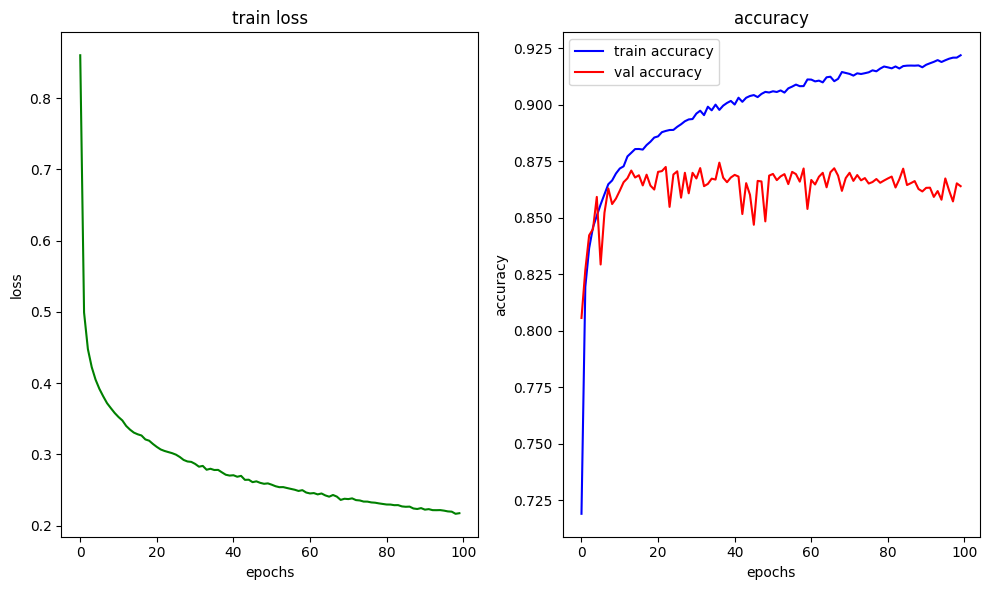

In [137]:
import tensorflow as tf
from tensorflow.keras.datasets import fashion_mnist
import numpy as np
import matplotlib.pyplot as plt

#1
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
##print("x_train.shape=", x_train.shape) # (60000, 28, 28)
##print("y_train.shape=", y_train.shape) # (60000,)
##print("x_test.shape=",  x_test.shape)  # (10000, 28, 28)
##print("y_test.shape=",  y_test.shape)  # (10000,)

#2:normalize images
x_train = x_train.astype('float32')
x_test  = x_test.astype('float32')
x_train /= 255.0 # [0.0, 1.0]
x_test  /= 255.0

#3: one-hot encoding
y_train = tf.keras.utils.to_categorical(y_train) # (60000, 10)
y_test = tf.keras.utils.to_categorical(y_test)   # (10000, 10)

#4: x_train.shape = (60000, 28, 28)
model = tf.keras.Sequential()
model.add(tf.keras.layers.Flatten(input_shape=(28, 28)))
model.add(tf.keras.layers.Dense(units=20, activation='sigmoid'))
model.add(tf.keras.layers.Dense(units=10, activation='softmax'))
model.summary()

opt = tf.keras.optimizers.RMSprop(learning_rate=0.01)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
ret = model.fit(x_train, y_train, epochs=100, batch_size=400,
                validation_split=0.2, verbose=2)

#5
y_pred = model.predict(x_train)
y_label = np.argmax(y_pred, axis = 1)
C = tf.math.confusion_matrix(np.argmax(y_train, axis = 1), y_label)
print("confusion_matrix(C):", C)
train_loss, train_acc = model.evaluate(x_train, y_train, verbose=2)
test_loss, test_acc = model.evaluate(x_test,  y_test, verbose=2)

#6
fig, ax = plt.subplots(1, 2, figsize=(10, 6))
ax[0].plot(ret.history['loss'],  "g-")
ax[0].set_title("train loss")
ax[0].set_xlabel('epochs')
ax[0].set_ylabel('loss')

ax[1].plot(ret.history['accuracy'],     "b-", label="train accuracy")
ax[1].plot(ret.history['val_accuracy'], "r-", label="val accuracy")
ax[1].set_title("accuracy")
ax[1].set_xlabel('epochs')
ax[1].set_ylabel('accuracy')
plt.legend(loc="best")
fig.tight_layout()
plt.show()

## Step28 - CIFAR-10 Dataset

* 10 종류의 사물 (개구리, 트럭 등) 의 컬러 이미지
* 훈련 데이터 5만개, 테스트 데이터 1만개
* 32 x 32, 3 채널(RGB)

x_train.shape= (50000, 32, 32, 3)
y_train.shape= (50000, 1)
x_test.shape= (10000, 32, 32, 3)
y_test.shape= (10000, 1)
y_train.shape= (50000,)
y_test.shape= (10000,)
nlabel: [0 1 2 3 4 5 6 7 8 9]
count: [5000 5000 5000 5000 5000 5000 5000 5000 5000 5000]
# of Class: 10
y_train[:8]= [6 9 9 4 1 1 2 7]


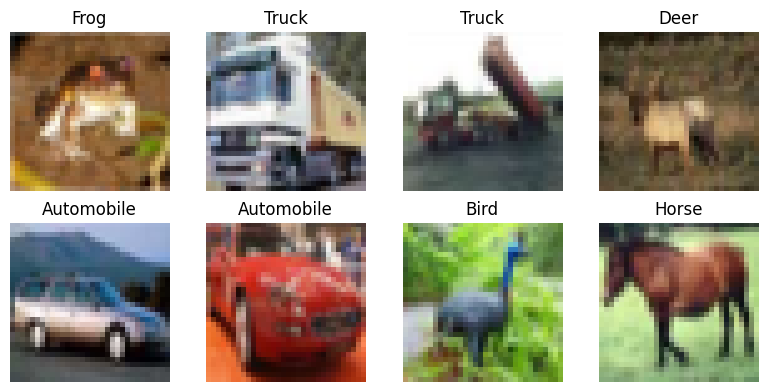

In [138]:
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
import numpy as np
import matplotlib.pyplot as plt
#1
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
print("x_train.shape=", x_train.shape) # (50000, 32, 32, 3)
print("y_train.shape=", y_train.shape) # (50000, 1)
print("x_test.shape=",  x_test.shape)  # (10000, 32, 32, 3)
print("y_test.shape=",  y_test.shape)  # (10000, 1)

#2
y_train = y_train.flatten() 
y_test  = y_test.flatten()
print("y_train.shape=", y_train.shape) # (50000,)
print("y_test.shape=",  y_test.shape)  # (10000,)

#3
nlabel, count = np.unique(y_train, return_counts=True)
print("nlabel:", nlabel)
print("count:",  count)
print("# of Class:",  len(nlabel) )

#4
label = ('Airplane', 'Automobile', 'Bird', 'Cat', 'Deer',
         'Dog', 'Frog', 'Horse', 'Ship', 'Truck')
print("y_train[:8]=",y_train[:8])

fig = plt.figure(figsize=(8, 4))
for i in range(8):
    plt.subplot(2, 4, i + 1, )  
    plt.imshow(x_train[i], cmap='gray')
    plt.gca().set_title(label[y_train[i]])
    plt.axis("off")
fig.tight_layout()
plt.show()

x_train.shape= (50000, 32, 32, 3)
y_train.shape= (50000, 1)
x_test.shape= (10000, 32, 32, 3)
y_test.shape= (10000, 1)
y_train.shape= (50000,)
y_test.shape= (10000,)
nlabel: [0 1 2 3 4 5 6 7 8 9]
count: [5000 5000 5000 5000 5000 5000 5000 5000 5000 5000]
# of Class: 10
y_train[:8]= [6 9 9 4 1 1 2 7]


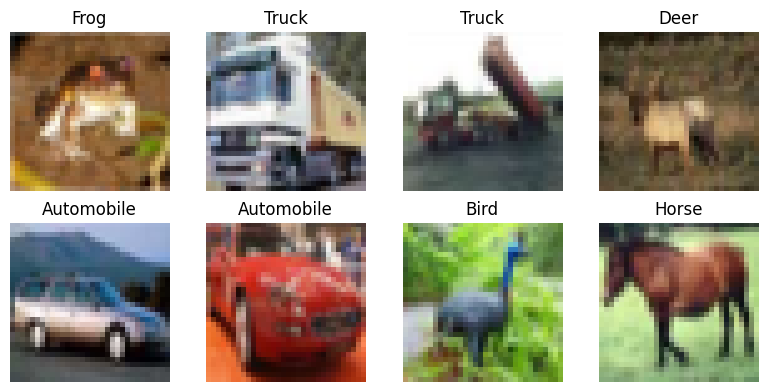

In [139]:
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
import numpy as np
import matplotlib.pyplot as plt
#1
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
print("x_train.shape=", x_train.shape) # (50000, 32, 32, 3)
print("y_train.shape=", y_train.shape) # (50000, 1)
print("x_test.shape=",  x_test.shape)  # (10000, 32, 32, 3)
print("y_test.shape=",  y_test.shape)  # (10000, 1)

#2
y_train = y_train.flatten() 
y_test  = y_test.flatten()
print("y_train.shape=", y_train.shape) # (50000,)
print("y_test.shape=",  y_test.shape)  # (10000,)

#3
nlabel, count = np.unique(y_train, return_counts=True)
print("nlabel:", nlabel)
print("count:",  count)
print("# of Class:",  len(nlabel) )

#4
label = ('Airplane', 'Automobile', 'Bird', 'Cat', 'Deer',
         'Dog', 'Frog', 'Horse', 'Ship', 'Truck')
print("y_train[:8]=",y_train[:8])

fig = plt.figure(figsize=(8, 4))
for i in range(8):
    plt.subplot(2, 4, i + 1, )  
    plt.imshow(x_train[i], cmap='gray')
    plt.gca().set_title(label[y_train[i]])
    plt.axis("off")
fig.tight_layout()
plt.show()

## Step29 - CIFAR-100 Dataset

* 100 종류의 사물들의 컬러 이미지
* 훈련 데이터 5만개, 테스트 데이터 1만개
* 32 x 32, 3 채널(RGB)

169001437/169001437 [==============================] - 14s 0us/step
x_train.shape= (50000, 32, 32, 3)
y_train.shape= (50000, 1)
x_test.shape= (10000, 32, 32, 3)
y_test.shape= (10000, 1)
y_train.shape= (50000,)
y_test.shape= (10000,)
nlabel: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]
count: [2500 2500 2500 2500 2500 2500 2500 2500 2500 2500 2500 2500 2500 2500
 2500 2500 2500 2500 2500 2500]
# of Class: 20
y_train[:8]= [11 15  4 14  1  5 18  3]


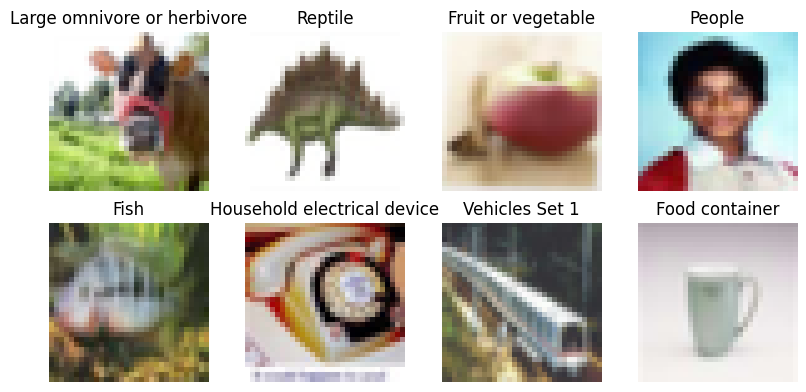

In [122]:
import tensorflow as tf
from tensorflow.keras.datasets import cifar100
import numpy as np
import matplotlib.pyplot as plt

#1
mode = 'coarse' # 'fine'
(x_train, y_train), (x_test, y_test) = cifar100.load_data(label_mode=mode)
print("x_train.shape=", x_train.shape) # (50000, 32, 32, 3)
print("y_train.shape=", y_train.shape) # (50000, 1)
print("x_test.shape=",  x_test.shape)  # (10000, 32, 32, 3)
print("y_test.shape=",  y_test.shape)  # (10000, 1)

#2
y_train = y_train.flatten() 
y_test  = y_test.flatten()
print("y_train.shape=", y_train.shape) # (50000,)
print("y_test.shape=",  y_test.shape)  # (10000,)

#3
nlabel, count = np.unique(y_train, return_counts=True)
print("nlabel:", nlabel)
print("count:",  count)
print("# of Class:",  len(nlabel) )

#4
#https://github.com/SteffenBauer/KerasTools/blob/master/KerasTools/datasets/decode.py
coarse_label = ('Aquatic mammal', 'Fish', 
               'Flower', 'Food container', 
               'Fruit or vegetable', 'Household electrical device', 
               'Household furniture', 'Insect', 
               'Large carnivore', 'Large man-made outdoor thing', 
               'Large natural outdoor scene', 'Large omnivore or herbivore',
               'Medium-sized mammal', 'Non-insect invertebrate',
               'People', 'Reptile', 
               'Small mammal', 'Tree',
               'Vehicles Set 1', 'Vehicles Set 2')
fine_label = ('Apple', 'Aquarium fish', 'Baby', 'Bear', 'Beaver', 
              'Bed', 'Bee', 'Beetle', 'Bicycle', 'Bottle', 
              'Bowl', 'Boy', 'Bridge', 'Bus', 'Butterfly', 
              'Camel', 'Can', 'Castle', 'Caterpillar', 'Cattle', 
              'Chair', 'Chimpanzee', 'Clock', 'Cloud', 'Cockroach', 
              'Couch', 'Crab', 'Crocodile', 'Cups', 'Dinosaur', 
              'Dolphin', 'Elephant', 'Flatfish', 'Forest', 'Fox', 
              'Girl', 'Hamster', 'House', 'Kangaroo', 'Computer keyboard',
              'Lamp', 'Lawn-mower', 'Leopard', 'Lion', 'Lizard', 
              'Lobster', 'Man', 'Maple', 'Motorcycle', 'Mountain', 
              'Mouse', 'Mushrooms', 'Oak', 'Oranges', 'Orchids', 
              'Otter', 'Palm', 'Pears', 'Pickup truck', 'Pine', 
              'Plain', 'Plates', 'Poppies', 'Porcupine', 'Possum', 
              'Rabbit', 'Raccoon', 'Ray', 'Road', 'Rocket', 
              'Roses', 'Sea', 'Seal', 'Shark', 'Shrew', 
              'Skunk', 'Skyscraper', 'Snail', 'Snake', 'Spider', 
              'Squirrel', 'Streetcar', 'Sunflowers', 'Sweet peppers', 'Table', 
              'Tank', 'Telephone', 'Television', 'Tiger', 'Tractor', 
              'Train', 'Trout', 'Tulips', 'Turtle', 'Wardrobe', 
              'Whale', 'Willow', 'Wolf', 'Woman', 'Worm')

print("y_train[:8]=",y_train[:8])
fig = plt.figure(figsize=(8, 4))
for i in range(8):
    plt.subplot(2, 4, i + 1, )  
    plt.imshow(x_train[i], cmap='gray')
    if mode == 'coarse':
        title = coarse_label[y_train[i]]
    else: # 'fine'
        title = fine_label[y_train[i]]        
    plt.gca().set_title(title)
    plt.axis("off")
fig.tight_layout()
plt.show()

Model: "sequential_37"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_9 (Flatten)         (None, 3072)              0         
                                                                 
 dense_90 (Dense)            (None, 100)               307300    
                                                                 
 dense_91 (Dense)            (None, 100)               10100     
                                                                 
Total params: 317,400
Trainable params: 317,400
Non-trainable params: 0
_________________________________________________________________
Epoch 1/200
200/200 - 1s - loss: 4.1234 - accuracy: 0.0973 - val_loss: 3.9258 - val_accuracy: 0.1240 - 1s/epoch - 6ms/step
Epoch 2/200
200/200 - 1s - loss: 3.7923 - accuracy: 0.1467 - val_loss: 3.7802 - val_accuracy: 0.1420 - 738ms/epoch - 4ms/step
Epoch 3/200
200/200 - 1s - loss: 3.6503 - accuracy: 0.1701 - v

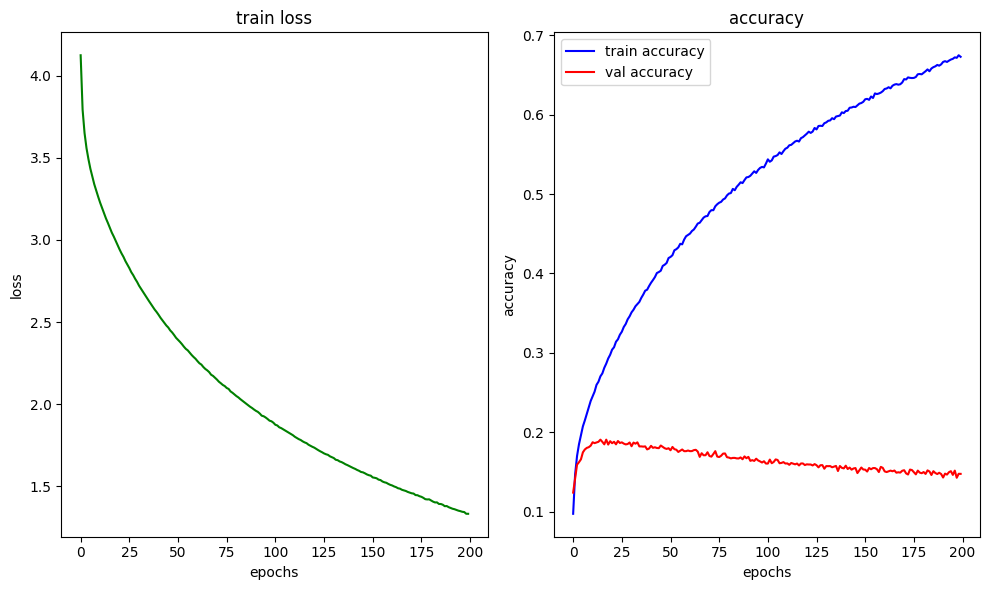

In [140]:
import tensorflow as tf
from tensorflow.keras.datasets import cifar100
import numpy as np
import matplotlib.pyplot as plt

#1
(x_train, y_train), (x_test, y_test) = cifar100.load_data() #' fine'
##print("x_train.shape=", x_train.shape) # (50000, 32, 32, 3)
##print("y_train.shape=", y_train.shape) # (50000, 1)
##print("x_test.shape=",  x_test.shape)  # (10000, 32, 32, 3)
##print("y_test.shape=",  y_test.shape)  # (10000, 1)

#2:normalize images
x_train = x_train.astype('float32')
x_test  = x_test.astype('float32')
def normalize_image(image): # 3-channel
    mean=  np.mean(image, axis = (0, 1, 2))
    std =  np.std(image,  axis = (0, 1, 2))
    image = (image-mean)/std
    return image
x_train= normalize_image(x_train) # range: N(mean=0, std=1]
x_test = normalize_image(x_test)

#3
nlabel, count = np.unique(y_train, return_counts=True)
nClass = len(nlabel) # 'fine': 100, 'coarse':20

#4: preprocessing the target(y_train, y_test)
y_train = y_train.flatten() 
y_test  = y_test.flatten()
##print("y_train.shape=", y_train.shape) # (50000,)
##print("y_test.shape=",  y_test.shape)  # (10000,)

# one-hot encoding: 'mse', 'categorical_crossentropy'
y_train = tf.keras.utils.to_categorical(y_train) # (50000, nClass)
y_test = tf.keras.utils.to_categorical(y_test)   # (10000, nClass)

#5
model = tf.keras.Sequential()
model.add(tf.keras.layers.Flatten(input_shape=(32, 32, 3)))
model.add(tf.keras.layers.Dense(units=100, activation='sigmoid'))
model.add(tf.keras.layers.Dense(units=nClass, activation='softmax'))
model.summary()

opt = tf.keras.optimizers.RMSprop(learning_rate=0.001)
model.compile(optimizer=opt, loss='categorical_crossentropy',
              metrics=['accuracy'])
ret = model.fit(x_train, y_train, epochs=200, batch_size=200, 
               validation_split=0.2, verbose=2)

#6
y_pred = model.predict(x_train)
y_label = np.argmax(y_pred, axis = 1)
C = tf.math.confusion_matrix(np.argmax(y_train, axis = 1), y_label)
print("confusion_matrix(C):", C)
train_loss, train_acc = model.evaluate(x_train, y_train, verbose=2)
test_loss, test_acc = model.evaluate(x_test,  y_test, verbose=2)

#7: plot accuracy and loss
fig, ax = plt.subplots(1, 2, figsize=(10, 6))
ax[0].plot(ret.history['loss'],  "g-")
ax[0].set_title("train loss")
ax[0].set_xlabel('epochs')
ax[0].set_ylabel('loss')

ax[1].plot(ret.history['accuracy'],     "b-", label="train accuracy")
ax[1].plot(ret.history['val_accuracy'], "r-", label="val accuracy")
ax[1].set_title("accuracy")
ax[1].set_xlabel('epochs')
ax[1].set_ylabel('accuracy')
plt.legend(loc="best")
fig.tight_layout()
plt.show()

# Note - tf.data API

tf.data API를 사용하면 단순하고 재사용 가능한 부분에서 복잡한 입력 파이프라인을 구축할 수 있음

* 이미지: 데이터 집계, 이미지 변화, 랜덤 배치 등
* 텍스트: symbol 추출, 사전 생성, 패딩 처리 등

참고자료

* [Module: tf.data](https://www.tensorflow.org/api_docs/python/tf/data)
* [TensorFlow Datasets](https://www.tensorflow.org/datasets/overview)
* [tf.data: Build TensorFlow input pipelines](https://www.tensorflow.org/guide/data)

In [123]:
import tensorflow as tf
import pathlib
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

np.set_printoptions(precision=4)

## tf.data.Dataset 만드는 방법

* data source 는 메모리(list 나 numpy 배열 등) 이나 파일(jpeg 나 csv) 로 부터 dataset 을 생성
* data transformation은 하나 이상의 tf.data.Dataset 객체로부터 dataset 을 생성

## python list 로 tf.data.Dataset 생성하기

In [124]:
natural_numbers = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

In [125]:
# Creates a Dataset whose elements are slices of the given tensors.
dataset = tf.data.Dataset.from_tensor_slices(natural_numbers)
print(list(dataset))

[<tf.Tensor: shape=(), dtype=int32, numpy=1>, <tf.Tensor: shape=(), dtype=int32, numpy=2>, <tf.Tensor: shape=(), dtype=int32, numpy=3>, <tf.Tensor: shape=(), dtype=int32, numpy=4>, <tf.Tensor: shape=(), dtype=int32, numpy=5>, <tf.Tensor: shape=(), dtype=int32, numpy=6>, <tf.Tensor: shape=(), dtype=int32, numpy=7>, <tf.Tensor: shape=(), dtype=int32, numpy=8>, <tf.Tensor: shape=(), dtype=int32, numpy=9>, <tf.Tensor: shape=(), dtype=int32, numpy=10>]


In [126]:
for num in dataset:
  print(num)

tf.Tensor(1, shape=(), dtype=int32)
tf.Tensor(2, shape=(), dtype=int32)
tf.Tensor(3, shape=(), dtype=int32)
tf.Tensor(4, shape=(), dtype=int32)
tf.Tensor(5, shape=(), dtype=int32)
tf.Tensor(6, shape=(), dtype=int32)
tf.Tensor(7, shape=(), dtype=int32)
tf.Tensor(8, shape=(), dtype=int32)
tf.Tensor(9, shape=(), dtype=int32)
tf.Tensor(10, shape=(), dtype=int32)


In [127]:
# Slicing a 2D tensor produces 1D tensor elements.
dataset = tf.data.Dataset.from_tensor_slices([[1, 2], [3, 4]])
print(list(dataset))
for num in dataset:
  print(num)

[<tf.Tensor: shape=(2,), dtype=int32, numpy=array([1, 2])>, <tf.Tensor: shape=(2,), dtype=int32, numpy=array([3, 4])>]
tf.Tensor([1 2], shape=(2,), dtype=int32)
tf.Tensor([3 4], shape=(2,), dtype=int32)


In [128]:
# Creates a Dataset with a single element, comprising the given tensors.
dataset2 = tf.data.Dataset.from_tensors(natural_numbers)
print(list(dataset2))

[<tf.Tensor: shape=(10,), dtype=int32, numpy=array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10])>]


In [129]:
for num in dataset2:
  print(num)

tf.Tensor([ 1  2  3  4  5  6  7  8  9 10], shape=(10,), dtype=int32)


In [130]:
for num in dataset.as_numpy_iterator():
  print(num)

[1 2]
[3 4]


In [131]:
for num in dataset.take(3):
  print(num)

tf.Tensor([1 2], shape=(2,), dtype=int32)
tf.Tensor([3 4], shape=(2,), dtype=int32)


In [132]:
for num in dataset.filter(lambda x: 5 < x):
  print(num)

ValueError: Invalid `predicate`. `predicate` must return a `tf.bool` scalar tensor, but its return type is TensorSpec(shape=(2,), dtype=tf.bool, name=None).

In [133]:
for num in dataset.map(lambda x: x**2):
  print(num)

tf.Tensor([1 4], shape=(2,), dtype=int32)
tf.Tensor([ 9 16], shape=(2,), dtype=int32)


In [134]:
for num in dataset.shuffle(3):
  print(num)

tf.Tensor([3 4], shape=(2,), dtype=int32)
tf.Tensor([1 2], shape=(2,), dtype=int32)


In [135]:
for num in dataset.batch(3):
  print(num)

tf.Tensor(
[[1 2]
 [3 4]], shape=(2, 2), dtype=int32)


In [136]:
for num in dataset\
          .map(lambda x: x**2)\
          .filter(lambda x: 5 < x)\
          .shuffle(3).batch(3):
  print(num)

ValueError: Invalid `predicate`. `predicate` must return a `tf.bool` scalar tensor, but its return type is TensorSpec(shape=(2,), dtype=tf.bool, name=None).

## numpy array 로 dataset 생성하기

In [ ]:
tensor_dataset_from_numpy = tf.data.Dataset.from_tensors(np.array([1, 2, 3]))
print('tensor_dataset_from_numpy', tensor_dataset_from_numpy)

# tf.data.Dataset 객체는 파이썬의 iterable 임
for elem in tensor_dataset_from_numpy:
  print('element', elem)

tensor_dataset_from_numpy <TensorDataset element_spec=TensorSpec(shape=(3,), dtype=tf.int64, name=None)>
element tf.Tensor([1 2 3], shape=(3,), dtype=int64)


In [ ]:
tensor_slice_dataset2 = tf.data.Dataset.from_tensor_slices(np.array([[1, 2, 3], [4, 5, 6]]))
print('tensor_slice_dataset2', tensor_slice_dataset2)

# tf.data.Dataset 객체는 파이썬의 iterable 임
for elem in tensor_slice_dataset2:
  print('element', elem)

tensor_slice_dataset2 <TensorSliceDataset element_spec=TensorSpec(shape=(3,), dtype=tf.int64, name=None)>
element tf.Tensor([1 2 3], shape=(3,), dtype=int64)
element tf.Tensor([4 5 6], shape=(3,), dtype=int64)


In [ ]:
train, test = tf.keras.datasets.fashion_mnist.load_data()
images, labels = train
print('images', type(images), images.shape)
print('labels', type(labels), labels.shape)

images <class 'numpy.ndarray'> (60000, 28, 28)
labels <class 'numpy.ndarray'> (60000,)


## tfds

https://knowyourdata-tfds.withgoogle.com/